# Model framework

**Example use (state: 6 June 2017)**

    from models import AverageModel
    avg = AverageModel()  # create model
    avg.predict()  # predict one time step into the future, return as pandas dataframe
    avg.predict_all()  # make predictions for all original time points, return as pandas dataframe
    avg.score()  # call predict_all() and return the mean squared error between the predictions and the actual polls

TODO:

- add column 'Datum' to prediction

- maybe: Implement Bayesian model as Model class
- maybe: store model results in case we use Monte Carlo (make class which stores results and pickle this)

In [1]:
# TODO: Dirty hack to import from sibling dir. Put wahlrecht_polling_firms.py into the same folder as this file eventually.
import sys
import os
sys.path.append(os.path.abspath('../Backend'))
#import wahlrecht_polling_firms
from APICalls.APICalls import getPollingData

import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import datetime

import preprocessing

## Data & Helper functions

In [2]:
parties = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']

In [3]:
data_dict = getPollingData(state=False)

In [4]:
data = preprocessing.average(data_dict, 'weightparticipants')
#data = pd.DataFrame.from_dict(data)
data

/Users/d068730/Projects/University/Predictor/models/preprocessing.py:77: RuntimeWarning: invalid value encountered in true_divide
  result[i,:] /= n


,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,Sonstige,Befragte,Datum
0,7.000000,39.000000,8.000000,8.000000,8.000000,24.000000,6.000000,2501.0,2017-07-09
1,10.965593,36.769863,5.722553,9.039010,8.819286,24.607410,4.076285,13253.0,2017-07-02
2,7.619187,38.775828,7.748120,7.918964,9.286271,24.399749,4.251880,7182.0,2017-06-25
3,7.521956,39.318696,8.566977,7.000000,8.614881,24.455533,4.521956,4509.0,2017-06-18
4,7.000000,38.000000,9.000000,8.000000,8.000000,24.000000,6.000000,2004.0,2017-06-11
5,8.487160,37.025680,7.538520,7.000000,10.025680,25.435801,4.487160,3972.0,2017-06-04
6,8.393823,36.735949,9.067140,7.212354,8.787646,25.673317,4.129772,5213.0,2017-05-28
7,7.952025,37.550616,8.244572,6.849619,8.851966,26.197183,4.354020,6816.0,2017-05-21
8,8.245768,37.073511,7.424138,6.968652,8.895141,26.607210,4.785580,6380.0,2017-05-14
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2017-05-07


In [5]:
pd.set_option('display.max_rows', len(data))
data

,AfD,CDU/CSU,FDP,GRÜNE,LINKE,SPD,Sonstige,Befragte,Datum
0,7.000000,39.000000,8.000000,8.000000,8.000000,24.000000,6.000000,2501.0,2017-07-09
1,10.965593,36.769863,5.722553,9.039010,8.819286,24.607410,4.076285,13253.0,2017-07-02
2,7.619187,38.775828,7.748120,7.918964,9.286271,24.399749,4.251880,7182.0,2017-06-25
3,7.521956,39.318696,8.566977,7.000000,8.614881,24.455533,4.521956,4509.0,2017-06-18
4,7.000000,38.000000,9.000000,8.000000,8.000000,24.000000,6.000000,2004.0,2017-06-11
5,8.487160,37.025680,7.538520,7.000000,10.025680,25.435801,4.487160,3972.0,2017-06-04
6,8.393823,36.735949,9.067140,7.212354,8.787646,25.673317,4.129772,5213.0,2017-05-28
7,7.952025,37.550616,8.244572,6.849619,8.851966,26.197183,4.354020,6816.0,2017-05-21
8,8.245768,37.073511,7.424138,6.968652,8.895141,26.607210,4.785580,6380.0,2017-05-14
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2017-05-07


In [6]:
def _normalize_to_hundred(x, axis=None):
    """Normalize an array so that its sum is 1."""
    x = np.asarray(x)
    return 100 * x / np.sum(x, axis=axis)

np.sum(_normalize_to_hundred(np.linspace(0, 10)))

100.00000000000001

In [7]:
def _prediction_to_dataframe(prediction):
    """Wrap an array with the predictions into a dataframe containing the party names."""
    return pd.DataFrame(data=[prediction], columns=parties)

_prediction_to_dataframe(range(len(parties)))

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,0,1,2,3,4,5,6


In [8]:
def mse(poll_df, prediction_df):
    """Calculate the mean squared error between the polling results in `poll_df` and the predictions in `prediction_df`. Average over all parties."""
    mse = 0
    for party in parties:
        # TODO: NaN values are not properly handled here. Disregard them for the mse calculation. 
        true_results = poll_df[party]
        predicted_results = prediction_df[party][1:1+len(poll_df)]  # first point is prediction into the future, do not use it
        mse += np.mean((true_results - predicted_results)**2)
    return mse / len(parties)

## Models

In [9]:
class Model():
    
    def fit(self, df=data):
        """Optional fit step to call before predictions. Leave empty if the model does not support fitting."""
        return
    
    def predict(self, df=data):
        raise NotImplementedError()
    
    def predict_all(self, df=data):
        """Make a prediction for each time point in the data."""
        #print('Applying model to {} time points...'.format(len(data)))

        # First prediction, append the other ones below.
        prediction_df = self.predict(df)

        for i in range(1, len(df)):
            # Note: Appending the data frames takes up almost no time here, the bottleneck is the model.
            prediction_df = prediction_df.append(self.predict(df[i:]), ignore_index=True)
        
        return prediction_df
    
    # TODO: With the new averaging in preprocessing, scoring the model against different polling firms isn't that simple any more. Maybe make a function in preprocessing that converts the data of a single polling firm to the weekly format.
    def score(self, data=data, polling_firm=None):
        """Calculate a score for the model (lower is better). The score is the mean squared error between the model's predictions and the true results.
        If `polling_firm` is None (default), return a dict with the score for each polling firm. Otherwise, return only the score for that polling firm."""
        prediction_df = self.predict_all(data)
        return mse(data, prediction_df)
    
        #if polling_firm is None:
        #    return {polling_firm: mse(poll_df, prediction_df) for polling_firm, poll_df in data_dict.items()}
        #else: 
        #    return mse(data_dict[polling_firm], prediction_df)

In [18]:
class PolynomialModel(Model):
    """Fit a polynomial of degree `degree` (from 0 to 3) through the last `n_last` polls and calculate one point into the future."""
    
    def __init__(self, n_last=5, degree=1):
        self.n_last = n_last
        self.degree = degree
        
    def predict(self, df=data):
        # TODO: Double-check that this works properly.
        prediction = []
        prediction_error = []
        
        if self.n_last == None:  # use all rows
            num_rows = len(df)
        else:  # use just the n_last rows
            num_rows = self.n_last
            
        data_for_regression = df[parties].iloc[:num_rows].fillna(0)
        x_pred = data_for_regression.index.values[0] - 1
        
        # TODO: Use dropna here.
        # Drop rows that contain only NaN values.
        data_for_regression = data_for_regression[[not (row == 0).all() for _, row in data_for_regression.iterrows()]]
        
        x = data_for_regression.index.values
        
        for party in parties:
            y = data_for_regression[party]
            
            if len(x) > 1 and len(y) > 1:
                #fit_params, fit_cov = np.polyfit(x, y, self.degree, cov=True)
                # Make the fit using scipy.optimize.curve_fit
                f = lambda x, *p: np.polyval(p, x)
                p0 = [1] * (self.degree+1)
                fit_params, fit_cov = sp.optimize.curve_fit(f, x, y, p0)  # TODO: Change f to just take the num of parameters.
                
                y_pred = np.poly1d(fit_params)(x_pred)
                y_error = np.sqrt(np.diag(np.absolute(fit_cov)))  # these is the uncertainty of the fit for the original data points
                y_error = np.mean(y_error)  # take the mean of all uncertainties to get an estimate of the prediction error
                if np.isinf(y_error):
                    y_error = 0
            else:
                y_pred = np.nan
                y_error = 0
                
            prediction.append(y_pred)
            prediction_error.append(y_error)
            
        prediction = _normalize_to_hundred(prediction)
        
        prediction_df = pd.DataFrame(columns=parties + ['Datum'], index=[0])
        prediction_df['Datum'].iloc[0] = df['Datum'].iloc[0] + datetime.timedelta(weeks=1)
        for i, party in enumerate(parties):
            mean = prediction[i]
            error = prediction_error[i]
            prediction_df[party][0] = [mean - error, mean, mean + error]
        return prediction_df
        
PolynomialModel(degree=2).predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[37.2767010165, 38.3881196671, 39.4995383177]","[23.2746713922, 23.4068804746, 23.5390895571]","[7.95741799371, 8.66482873851, 9.37223948331]","[7.54977622618, 8.46131746532, 9.37285870446]","[6.45433480987, 6.60205420404, 6.7497735982]","[4.67808395762, 6.19147686248, 7.70486976734]","[8.02943889239, 8.28532258791, 8.54120628343]",2017-07-16 00:00:00


In [20]:
class LinearModel(PolynomialModel):
    """Fit a line through the last `n_last` polls and calculate one point into the future."""
    
    def __init__(self, n_last=5):
        PolynomialModel.__init__(self, n_last=n_last, degree=1)
        
LinearModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[37.5683815875, 38.2082278114, 38.8480740354]","[24.1638948469, 24.3381013585, 24.51230787]","[8.19636535954, 8.6032978331, 9.01023030667]","[5.72130530441, 6.35420303654, 6.98710076867]","[8.25767356303, 8.60540921156, 8.95314486009]","[8.05964535181, 9.05443811042, 10.049230869]","[4.23743575312, 4.83632263847, 5.43520952382]",2017-07-16 00:00:00


In [27]:
class DecayModel(Model):
    """Average the last `n_last` polls (`None`, i.e. all by default), where polls further back are weighted less (exponential decay)."""
    
    def __init__(self, n_last=None, decay_factor=0.9):
        self.n_last = n_last
        self.decay_factor = decay_factor
    
    def fit(self):
        # TODO: Fit decay_factor to get best results.
        pass
        
    # TODO: Maybe generalize by letting AverageModel and DecayModel inherit from each other or common base class.
    def predict(self, df=data):
        prediction = np.zeros(len(parties))
        prediction_error = np.zeros(len(parties))
        
        if self.n_last == None:  # use all rows
            num_rows = len(df)
        else:  # use just the n_last rows
            num_rows = self.n_last
            
        # TODO: Take decaying average of uncertainties according to p * (1-p) / n.
            
        for i in range(min(num_rows, len(df))):  # do not use more rows than the dataframe has
            results = df[parties].iloc[i].fillna(0)
            if not (results == 0).all():  # ignore empty rows
                prediction += results * self.decay_factor**(i+1)
                
                # Calculate error according to formula from paper: sqrt(p * (1-p) / n)
                p = results / 100
                n = df['Befragte'].fillna(0).iloc[i]
                if n > 0:
                    errors = 100 * np.sqrt(p * (1 - p) / n)
                    prediction_error += errors * self.decay_factor**(i+1)
            
        prediction = _normalize_to_hundred(prediction)
        
        prediction_df = pd.DataFrame(index=[0], columns=parties + ['Datum'])
        prediction_df['Datum'].iloc[0] = df['Datum'].iloc[0] + datetime.timedelta(weeks=1)
        for i, party in enumerate(parties):
            mean = prediction[i]
            error = prediction_error[i]
            prediction_df[party][0] = [mean - error, mean, mean + error]
            
        return prediction_df
    
DecayModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[30.9619279803, 36.7048526578, 42.4477773354]","[20.5630270018, 25.7857598142, 31.0084926267]","[4.61823898767, 7.82848458781, 11.0387301879]","[4.14671585779, 7.24742456978, 10.3481332818]","[5.44469639878, 8.78949715995, 12.1342979211]","[5.55625085905, 8.91458694759, 12.2729230361]","[2.15912288612, 4.72939426282, 7.29966563951]",2017-07-23 00:00:00


In [28]:
class AverageModel(DecayModel):
    """Average the last `n_last` polls (5 by default)."""
    
    def __init__(self, n_last=5):
        DecayModel.__init__(self, n_last=n_last, decay_factor=1)
        
AverageModel().predict(data)

,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[35.7695909124, 38.4660969572, 41.1626030019]","[21.9906353774, 24.3656730986, 26.7407108197]","[6.49933195083, 7.98949352808, 9.47965510534]","[6.03290043595, 7.50941271042, 8.98592498489]","[7.13097406973, 8.68010969535, 10.229245321]","[6.78924235047, 8.27668390996, 9.76412546946]","[3.51836069936, 4.71253010047, 5.90669950158]",2017-07-23 00:00:00


In [29]:
AverageModel().predict_all(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[35.7695909124, 38.4660969572, 41.1626030019]","[21.9906353774, 24.3656730986, 26.7407108197]","[6.49933195083, 7.98949352808, 9.47965510534]","[6.03290043595, 7.50941271042, 8.98592498489]","[7.13097406973, 8.68010969535, 10.229245321]","[6.78924235047, 8.27668390996, 9.76412546946]","[3.51836069936, 4.71253010047, 5.90669950158]",2017-07-23 00:00:00
1,"[34.5920981686, 38.3728775657, 42.1536569628]","[20.9634674036, 24.2925384788, 27.6216095541]","[5.89540893129, 7.99159482246, 10.0877807136]","[5.69173498722, 7.80753016834, 9.92332534946]","[6.38892781674, 8.54408775628, 10.6992476958]","[5.96394916716, 8.02134712797, 10.0787450888]","[3.24534819886, 4.97002408038, 6.69469996189]",2017-07-16 00:00:00
2,"[34.4063627731, 37.9780135174, 41.5496642617]","[21.4136146999, 24.5796985997, 27.7457824995]","[5.83304455373, 7.79159482246, 9.7501450912]","[5.7230086528, 7.71523409583, 9.70745953886]","[6.85998827254, 8.94922370794, 11.0384591433]","[6.32937436069, 8.31877915214, 10.3081839436]","[3.08917658743, 4.66745610454, 6.24573562166]",2017-07-09 00:00:00
3,"[34.150724229, 37.97123055, 41.7917368709]","[21.3959216348, 24.7928800127, 28.1898383907]","[5.35849458623, 7.42626356158, 9.49403253693]","[6.19599258506, 8.38415138754, 10.57231019]","[6.70786654007, 8.94289572186, 11.1779249037]","[5.70237855552, 7.80442523983, 9.90647192415]","[2.9960519144, 4.67815352649, 6.36025513858]",2017-07-02 00:00:00
4,"[33.8940637503, 37.7261880974, 41.5583124445]","[21.7296052187, 25.1523667577, 28.5751282968]","[5.1573055279, 7.21239445513, 9.26748338236]","[6.27761008162, 8.48344164664, 10.6892732117]","[6.61942923704, 8.85603466762, 11.0926400982]","[5.75429887125, 7.87099279821, 9.98768672516]","[3.00738519046, 4.69858157725, 6.38977796405]",2017-06-25 00:00:00
5,"[33.5677518859, 37.2771511035, 40.986550321]","[22.2468003018, 25.5827020885, 28.9186038751]","[5.21223594125, 7.20612486266, 9.20001378406]","[6.1376224837, 8.25487380149, 10.3721251193]","[6.73693366919, 8.9120866111, 11.087239553]","[5.9474725289, 8.01575518566, 10.0840378424]","[3.1023045754, 4.75130634715, 6.40030811889]",2017-06-18 00:00:00
6,"[34.4713130141, 37.0964388793, 39.7215647445]","[23.596509178, 25.9783776106, 28.3602460431]","[5.61979147083, 7.00765607832, 8.39552068581]","[6.59062384072, 8.06859225186, 9.546560663]","[7.57097963589, 9.14010826388, 10.7092368919]","[6.77136772663, 8.26969398207, 9.76802023751]","[3.32063764259, 4.43913293393, 5.55762822528]",2017-06-11 00:00:00
7,"[34.4864498601, 36.9528335304, 39.4192172007]","[23.7292534578, 25.9694991384, 28.209744819]","[5.97183382061, 7.30058376229, 8.62933370398]","[6.30716810791, 7.66409136448, 9.02101462104]","[7.46710706281, 8.92374885313, 10.3803906435]","[7.41591930266, 8.86485202449, 10.3137847463]","[3.28622720452, 4.32439132679, 5.36255544906]",2017-06-04 00:00:00
8,"[34.3879160993, 36.5617423216, 38.735568544]","[25.0988292652, 27.0946676777, 29.0905060902]","[6.04105682759, 7.2099613831, 8.37886593862]","[5.74581505846, 6.89126548293, 8.0367159074]","[7.53556715523, 8.81757454056, 10.0995819259]","[7.85304443387, 9.14858671119, 10.4441289885]","[3.36084246562, 4.27620188288, 5.19156130014]",2017-05-28 00:00:00
9,"[33.7556524914, 35.8760800048, 37.9965075182]","[26.2214967634, 28.2006080298, 30.1797192962]","[6.02550077536, 7.16791876624, 8.31033675713]","[5.28129915618, 6.36203414594, 7.44276913569]","[7.50837497766, 8.76050814077, 10.0126413039]","[8.21147472371, 9.50562627138, 10.799777819]","[3.24619050451, 4.12722464108, 5.00825877764]",2017-05-21 00:00:00


In [16]:
class LatestModel(AverageModel):
    """Use the latest poll."""
    
    def __init__(self):
        AverageModel.__init__(self, n_last=1)
    
LatestModel().predict(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]",2017-07-23 00:00:00


In [10]:
try:
    import GPflow
except ImportError:
    print('GPflow not installed, GPModel cannot be used')

class GPModel(Model):
    """In contrast to the other models, GPModel always makes predictions for all time points. Therefore, `predict` just returns the latest data point from `predict_all`."""
    
    def __init__(self, k=GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2)):
        self.kernel=k
        
    def predict(self, df=data):
        return self.predict_all(df).iloc[0]
    
    def predict_all(self, df=data):
        Y = df[parties]
        Y = Y.dropna(how='all').fillna(0)
        X = Y.index.values
        
        #X = pd.to_datetime(data.Datum)
        #X=-(X-dt.date.today()).astype('timedelta64[D]').reshape(-1,1)
        X = -X.reshape(-1,1).astype(float)
        
        #print(Y)

        m = GPflow.gpr.GPR(X, pd.DataFrame.as_matrix(Y), kern=self.kernel)
        m.optimize()
        
        x_pred = np.linspace(X[0,0],X[-1,0], 1000).reshape(-1,1)

        mean, var = m.predict_y(x_pred)
        stds = np.sqrt(var)
        # TODO: Integrate this into _normalize_to_hundred.

        prediction = 100 * mean / np.sum(mean, axis=1).reshape(-1, 1)
        prediction_df = pd.DataFrame(index=range(len(prediction)), columns=parties + ['Datum'])
        prediction_df['Datum'] = df['Datum']
       
        for j in range(len(prediction)):
            for i, party in enumerate(parties):
                mean = prediction[j, i]
                std  = stds[j,i] *2
                
                prediction_df[party][j] = [mean-std, mean, mean+std]
        
        return prediction_df
    
newdf = GPModel().predict_all(data)
newdf

#lower = newdf.applymap(lambda x : x[0])
#upper = newdf.applymap(lambda x : x[2])
#mean = newdf.applymap(lambda x : x[1])
#import matplotlib.pyplot as plt
#%matplotlib inline
#plt.figure(figsize=(12,12))
#for party in parties:
#    print(lower[party].sum())
#    plt.fill_between(np.arange(len(mean[party])),lower[party],upper[party],alpha=.3)
#    plt.plot(mean[party])

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige,Datum
0,"[36.3964111818, 38.6097675222, 40.8231238626]","[21.9858170923, 24.1991734327, 26.412529773]","[5.62120158741, 7.83455792781, 10.0479142682]","[5.70764635828, 7.92100269868, 10.1343590391]","[6.49057530887, 8.70393164927, 10.9172879897]","[5.70340127443, 7.91675761482, 10.1301139552]","[2.60145281421, 4.8148091546, 7.028165495]",2017-07-16
1,"[36.3102644589, 38.5035810169, 40.6968975749]","[22.148030053, 24.341346611, 26.534663169]","[5.60786019347, 7.80117675148, 9.99449330949]","[5.70085086068, 7.89416741868, 10.0874839767]","[6.51315832448, 8.70647488249, 10.8997914405]","[5.76006068176, 7.95337723977, 10.1466937978]","[2.60655952168, 4.79987607969, 6.9931926377]",2017-07-09
2,"[36.2211038826, 38.3964930221, 40.5718821616]","[22.3093704458, 24.4847595854, 26.6601487249]","[5.59212737771, 7.76751651723, 9.94290565675]","[5.69171318612, 7.86710232564, 10.0424914652]","[6.53358012013, 8.70896925965, 10.8843583992]","[5.81483928251, 7.99022842203, 10.1656175615]","[2.60954172849, 4.78493086801, 6.96032000752]",2017-07-02
3,"[36.1290479059, 38.2885276398, 40.4480073738]","[22.4699290652, 24.6294087991, 26.7888885331]","[5.57411295636, 7.7335926903, 9.89307242424]","[5.68032833497, 7.8398080689, 9.99928780284]","[6.5518641348, 8.71134386873, 10.8708236027]","[5.86774855719, 8.02722829113, 10.1867080251]","[2.61061090806, 4.770090642, 6.92957037594]",2017-06-25
4,"[36.0341577602, 38.1796334215, 40.3251090827]","[22.6298174952, 24.7752931565, 26.9207688178]","[5.55400690539, 7.69948256666, 9.84495822794]","[5.66670733046, 7.81218299174, 9.95765865301]","[6.56805744053, 8.71353310181, 10.8590087631]","[5.91896035073, 8.06443601201, 10.2099116733]","[2.60996308857, 4.75543874984, 6.90091441112]",2017-06-18
5,"[35.9364318898, 38.0696815268, 40.2029311637]","[22.7891643615, 24.9224139985, 27.0556636354]","[5.53207722378, 7.66532686072, 9.79857649767]","[5.65077092316, 7.7840205601, 9.91727019705]","[6.58222713302, 8.71547676996, 10.8487264069]","[5.96880669765, 8.1020563346, 10.2353059715]","[2.60777431245, 4.74102394939, 6.87427358633]",2017-06-11
6,"[35.8358777993, 37.9585509905, 40.0812241817]","[22.9480912049, 25.0707643961, 27.1934375873]","[5.50859992267, 7.63127311385, 9.75394630503]","[5.63243588575, 7.75510907693, 9.87778226811]","[6.59445084475, 8.71712403592, 10.8397972271]","[6.01761954521, 8.14029273639, 10.2629659276]","[2.60421245911, 4.72688565029, 6.84955884147]",2017-06-04
7,"[35.7325624685, 37.8461688585, 39.9597752485]","[23.1066954456, 25.2203018355, 27.3339082255]","[5.48387959146, 7.59748598143, 9.71109237141]","[5.61162821623, 7.72523460621, 9.83884099618]","[6.60485625509, 8.71846264506, 10.832069035]","[6.06570943808, 8.17931582805, 10.292922218]","[2.59942385521, 4.71303024519, 6.82663663516]",2017-05-28
8,"[35.6265643821, 37.7324776793, 39.8383909764]","[23.2650595139, 25.370972811, 27.4768861082]","[5.45822032092, 7.56413361805, 9.67004691518]","[5.5882709018, 7.69418419893, 9.80009749606]","[6.61357706723, 8.71949036436, 10.8254036615]","[6.1133729349, 8.21928623203, 10.3251995292]","[2.59354179918, 4.69945509631, 6.80536839344]",2017-05-21
9,"[35.5180334849, 37.6174916082, 39.7169497315]","[23.4232261879, 25.5226843112, 27.6221424345]","[5.43189899158, 7.53135711487, 9.63081523816]","[5.5623268964, 7.66178501969, 9.76124314298]","[6.62074193131, 8.7202000546, 10.8196581779]","[6.16087470823, 8.26033283152, 10.3597909548]","[2.58669093661, 4.6861490599, 6.78560718319]",2017-05-14


# Quick and dirty evaluation

In [59]:
AverageModel().predict_all(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Sonstige
0,38.095000,24.705000,7.125000,8.660000,9.220000,8.000000,4.195000
1,38.220000,24.605000,7.275000,8.635000,8.920000,7.850000,4.495000
2,38.000000,25.045000,7.175000,8.535000,8.660000,7.990000,4.595000
3,37.575000,25.720000,7.250000,8.235000,8.610000,8.140000,4.470000
4,36.975000,26.595000,7.175000,7.885000,8.585000,8.290000,4.495000
5,36.555000,27.515000,7.195000,7.345000,8.645000,8.410000,4.335000
6,36.080000,28.490000,6.995000,6.745000,8.695000,8.710000,4.285000
7,35.460000,29.385000,7.020000,6.370000,8.680000,8.970000,4.115000
8,35.110000,30.210000,6.895000,6.045000,8.630000,8.970000,4.140000
9,34.660000,31.035000,6.870000,5.920000,8.480000,8.870000,4.165000


In [60]:
AverageModel().score(data)

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


0.7974966867674459

In [61]:
models = [AverageModel, LatestModel, DecayModel]

In [25]:
# Depreceated.

# MSE for all models.

# TODO: Maybe show a pandas table or a pcolor plot instead of the tabulate table here.
mse_df = pd.DataFrame(columns=data_dict.keys(), index=[model.__name__ for model in models])
for model in models:
    print('Running model: {}'.format(model.__name__))
    mse_dict = model().score(data_dict)
    mse_df.loc[model.__name__] = pd.Series(mse_dict)
    #result_table.append([model.__name__, *mses.values()])

print()
print('MSE between predicted results from model (vertical) and polls (horizontal):')

mse_df

Running model: AverageModel
Running model: WeightedAverageModel
Running model: LatestModel
Running model: WeightedLatestModel
Running model: DecayModel
Running model: WeightedDecayModel

MSE between predicted results from model (vertical) and polls (horizontal):


,allensbach,emnid,forsa,politbarometer,gms,dimap,insa
AverageModel,4.39424,1.9992,1.89508,5.13031,11.6376,3.95384,3.5941
WeightedAverageModel,6.7288,1.22622,1.26525,7.58613,15.1602,4.81996,2.67714
LatestModel,4.58096,1.76355,1.5239,5.12015,11.7845,3.97941,3.23137
WeightedLatestModel,7.05105,0.978359,0.872095,7.81436,15.4589,5.21948,2.31105
DecayModel,3.97555,2.53056,2.41619,4.70169,11.5139,3.79322,4.14285
WeightedDecayModel,5.99084,1.86884,1.88422,6.29939,14.4698,3.95591,3.32519


In [63]:
prediction_data_dict = {model.__name__: model().predict_all(data) for model in models}

/Users/d068730/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


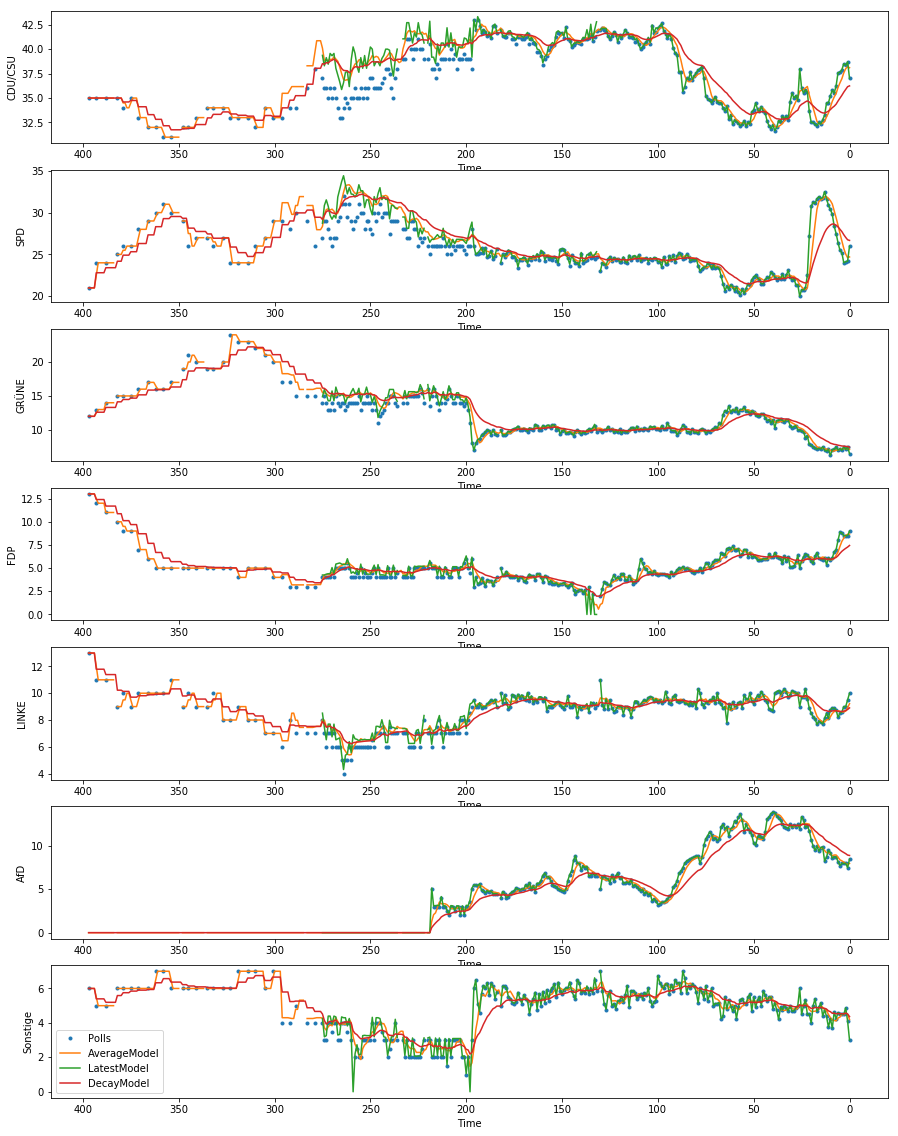

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(len(parties), figsize=(15, 20))

for ax, party in zip(axes, parties):
    plt.sca(ax)
    
    plt.plot(data[party], '.', label='Polls')

    for model, df in prediction_data_dict.items():
        plt.plot(df[party], label=model)
        
    #for polling_institute, df in data_dict.items():
    #    plt.plot(df[party], '--', label=polling_institute)

    #plt.legend()
    plt.gca().invert_xaxis()  # TODO: Time is inverted in data frames. Handle that somehow.
    plt.ylabel(party)
    plt.xlabel('Time')
    
plt.legend()